In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torchvision import datasets, transforms, models
# Thiết lập device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Đường dẫn dữ liệu
data_dir = '/content/drive/MyDrive/knee_dataset'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Tiền xử lý dữ liệu
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Device: cuda


In [ ]:
# Load dữ liệu
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Train samples: 5788, Val samples: 826, Test samples: 1656
Classes: ['0', '1', '2', '3', '4']


In [ ]:
#Tải mô hình ResNet18
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 5)  # 5 lớp
model = model.to(device)

# Loss và Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


In [ ]:
# Huấn luyện
num_epochs = 25
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{(total_correct/total_samples*100):.2f}%'})

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = total_correct.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        pbar_val = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Validation")
        for images, labels in pbar_val:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)
            val_total += labels.size(0)

            pbar_val.set_postfix({'val_loss': f'{loss.item():.4f}'})

    val_loss = val_loss / len(val_dataset)
    val_acc = val_correct.double() / len(val_dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch [1/25] - Validation: 100%|██████████| 26/26 [05:00<00:00, 11.54s/it, val_loss=1.7492]


Epoch [1/25], Loss: 1.2862, Acc: 0.4473, Val Loss: 1.0986, Val Acc: 0.5145


Epoch [2/25] - Validation: 100%|██████████| 26/26 [00:03<00:00,  7.86it/s, val_loss=0.7057]


Epoch [2/25], Loss: 0.9798, Acc: 0.5867, Val Loss: 0.9563, Val Acc: 0.5835


Epoch [3/25] - Validation: 100%|██████████| 26/26 [00:04<00:00,  5.58it/s, val_loss=0.6810]


Epoch [3/25], Loss: 0.8516, Acc: 0.6429, Val Loss: 0.9497, Val Acc: 0.6077


Epoch [4/25] - Validation: 100%|██████████| 26/26 [00:03<00:00,  7.99it/s, val_loss=0.4124]


Epoch [4/25], Loss: 0.7689, Acc: 0.6774, Val Loss: 0.9242, Val Acc: 0.5956


Epoch [5/25] - Validation: 100%|██████████| 26/26 [00:03<00:00,  7.36it/s, val_loss=0.5279]


Epoch [5/25], Loss: 0.7042, Acc: 0.7089, Val Loss: 1.1165, Val Acc: 0.5436


Epoch [6/25] - Validation: 100%|██████████| 26/26 [00:03<00:00,  6.57it/s, val_loss=0.2378]


Epoch [6/25], Loss: 0.6256, Acc: 0.7415, Val Loss: 0.9590, Val Acc: 0.6138


Epoch [7/25] - Validation: 100%|██████████| 26/26 [00:03<00:00,  7.60it/s, val_loss=0.6707]


Epoch [7/25], Loss: 0.5627, Acc: 0.7680, Val Loss: 1.0310, Val Acc: 0.5847


Epoch [8/25] - Validation: 100%|██████████| 26/26 [00:04<00:00,  5.56it/s, val_loss=0.7037]


Epoch [8/25], Loss: 0.5152, Acc: 0.7920, Val Loss: 1.1505, Val Acc: 0.6138


Epoch [9/25] - Validation: 100%|██████████| 26/26 [00:03<00:00,  7.45it/s, val_loss=0.4775]


Epoch [9/25], Loss: 0.4408, Acc: 0.8309, Val Loss: 1.0839, Val Acc: 0.6235


Epoch [10/25] - Validation: 100%|██████████| 26/26 [00:04<00:00,  6.39it/s, val_loss=0.3350]


Epoch [10/25], Loss: 0.3510, Acc: 0.8682, Val Loss: 1.1378, Val Acc: 0.5908


Epoch [11/25] - Validation: 100%|██████████| 26/26 [00:03<00:00,  7.44it/s, val_loss=0.2959]


Epoch [11/25], Loss: 0.3104, Acc: 0.8880, Val Loss: 1.1557, Val Acc: 0.5775


Epoch [12/25] - Validation: 100%|██████████| 26/26 [00:03<00:00,  7.20it/s, val_loss=0.5407]


Epoch [12/25], Loss: 0.2748, Acc: 0.9026, Val Loss: 1.1988, Val Acc: 0.5993


Epoch [13/25] - Validation: 100%|██████████| 26/26 [00:04<00:00,  6.19it/s, val_loss=0.2814]


Epoch [13/25], Loss: 0.2227, Acc: 0.9238, Val Loss: 1.3484, Val Acc: 0.5484


Epoch [14/25] - Validation: 100%|██████████| 26/26 [00:03<00:00,  7.56it/s, val_loss=0.5595]


Epoch [14/25], Loss: 0.1991, Acc: 0.9290, Val Loss: 1.3869, Val Acc: 0.5533


Epoch [15/25] - Validation: 100%|██████████| 26/26 [00:03<00:00,  6.76it/s, val_loss=0.2249]


Epoch [15/25], Loss: 0.1740, Acc: 0.9430, Val Loss: 1.4781, Val Acc: 0.5872


Epoch [16/25] - Validation: 100%|██████████| 26/26 [00:03<00:00,  7.90it/s, val_loss=1.1813]


Epoch [16/25], Loss: 0.1624, Acc: 0.9407, Val Loss: 1.4325, Val Acc: 0.5787


Epoch [17/25] - Validation: 100%|██████████| 26/26 [00:03<00:00,  7.46it/s, val_loss=0.4100]


Epoch [17/25], Loss: 0.1252, Acc: 0.9599, Val Loss: 1.4345, Val Acc: 0.5581


Epoch [18/25] - Validation: 100%|██████████| 26/26 [00:03<00:00,  7.12it/s, val_loss=0.4648]


Epoch [18/25], Loss: 0.0989, Acc: 0.9665, Val Loss: 1.5256, Val Acc: 0.5835


Epoch [19/25] - Validation: 100%|██████████| 26/26 [00:03<00:00,  7.79it/s, val_loss=0.5651]


Epoch [19/25], Loss: 0.0843, Acc: 0.9734, Val Loss: 1.6319, Val Acc: 0.5884


Epoch [20/25] - Validation: 100%|██████████| 26/26 [00:04<00:00,  5.39it/s, val_loss=0.6571]


Epoch [20/25], Loss: 0.0822, Acc: 0.9698, Val Loss: 1.6555, Val Acc: 0.5835


Epoch [21/25] - Validation: 100%|██████████| 26/26 [00:03<00:00,  7.87it/s, val_loss=0.5402]


Epoch [21/25], Loss: 0.1031, Acc: 0.9601, Val Loss: 1.7920, Val Acc: 0.5969


Epoch [22/25] - Validation: 100%|██████████| 26/26 [00:03<00:00,  7.21it/s, val_loss=0.6990]


Epoch [22/25], Loss: 0.0861, Acc: 0.9708, Val Loss: 1.6885, Val Acc: 0.6017


Epoch [23/25] - Validation: 100%|██████████| 26/26 [00:03<00:00,  7.05it/s, val_loss=0.8042]


Epoch [23/25], Loss: 0.0891, Acc: 0.9686, Val Loss: 1.6355, Val Acc: 0.6005


Epoch [24/25] - Validation: 100%|██████████| 26/26 [00:03<00:00,  8.02it/s, val_loss=0.2677]


Epoch [24/25], Loss: 0.0720, Acc: 0.9737, Val Loss: 1.6846, Val Acc: 0.6102


Epoch [25/25] - Validation: 100%|██████████| 26/26 [00:04<00:00,  5.37it/s, val_loss=0.4823]

Epoch [25/25], Loss: 0.0615, Acc: 0.9815, Val Loss: 1.7009, Val Acc: 0.5993


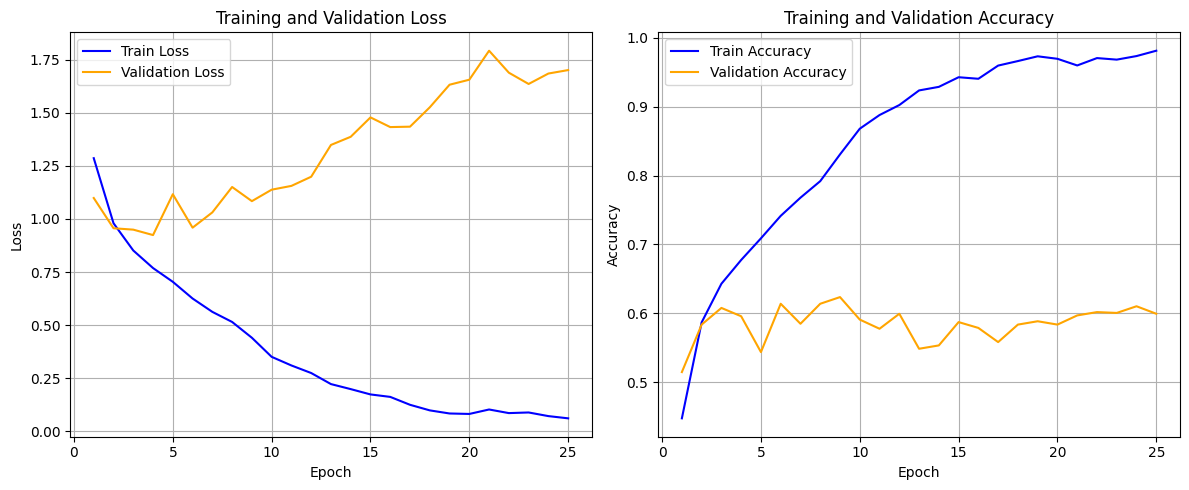

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 5))

# Biểu đồ Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label='Train Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accs, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()